In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.notebook import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

In [8]:
# Hyper-parameters
BATCH_SIZE = 32

imgs = os.listdir('/home/filnow/Desktop/data/train')
imgs_test = os.listdir('/home/filnow/Desktop/data/test')

train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

class CatsDogsDataset(Dataset):
    def __init__(self, imgs, root_dir, transform=None):
        self.imgs = imgs
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imgs[idx])
        image = Image.open(img_name)
        label =  0 if self.imgs[idx].split('.')[0] == 'cat' else 1

        if self.transform:
            image = self.transform(image)
        return image, label

#NOTE hard coded mean and std for imagenet

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = CatsDogsDataset(train_imgs, '/home/filnow/Desktop/data/train', transform=transform_train)
val_dataset = CatsDogsDataset(val_imgs, '/home/filnow/Desktop/data/train', transform=transform_test)
test_dataset = CatsDogsDataset(imgs_test, '/home/filnow/Desktop/data/test', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 0])


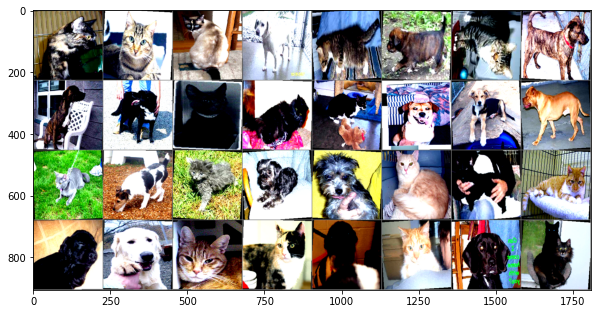

In [20]:
#Visualize some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.avg = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avg(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x


In [ ]:
num_epochs = 10
learning_rate = 0.001

model = Model().to(device)

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):

    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')

    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the {total} test images: {100 * correct / total}%')

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


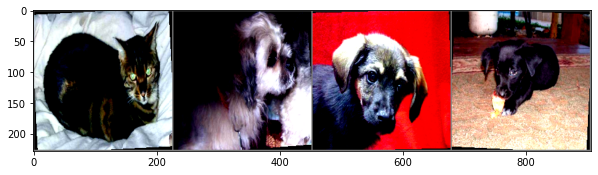

Predicted:    cat   cat   cat   cat


In [15]:
#Test on single images from test set
model.eval()

class_names = ['cat', 'dog']

with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    imshow(torchvision.utils.make_grid(images[:4]))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))
        